In [2]:
import numpy as np
import os
import librosa
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import audiosegment as aud
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim, ylim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.models import Model
from keras.layers import Input, Permute, Reshape, Lambda, Dot, Softmax
from keras.layers import Add, BatchNormalization, Conv2D, Dense, LSTM, Bidirectional
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [3]:
def AttRNNSpeechModel(input_shape, rnn_func = LSTM):
    
    inputs = Input((input_shape[0], input_shape[1]), name='input')

    x = Reshape((input_shape[0], input_shape[1], 1)) (inputs)

#     x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
#                              padding='same', sr=sr, n_mels=80,
#                              fmin=40.0, fmax=sr/2, power_melgram=1.0,
#                              return_decibel_melgram=True, trainable_fb=False,
#                              trainable_kernel=False,
#                              name='mel_stft') (x)

#     x = Normalization2D(int_axis=0)(x)

    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs

    x = Permute((2,1,3)) (x)

    x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
    x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)

    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

    x = Bidirectional(rnn_func(64, return_sequences = True, dropout=0.3)) (x) # [b_s, seq_len, vec_dim]
    x = Bidirectional(rnn_func(64, return_sequences = True, dropout=0.3)) (x) # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:,64]) (x) #[b_s, vec_dim]
    query = Dense(128) (xFirst)

    #dot product attention
    attScores = Dot(axes=[1,2])([query, x]) 
    attScores = Softmax(name='attSoftmax')(attScores) #[b_s, seq_len]

    #rescale sequence
    attVector = Dot(axes=[1,1])([attScores, x]) #[b_s, vec_dim]

    x = Dense(64, activation = 'relu')(attVector)
    x = Dense(32)(x)

    output = Dense(1, activation = 'sigmoid', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [4]:
train_path_0 = '/home/anton/Documents/final_set/0/'
train_path_1 = '/home/anton/Documents/final_set/1/'

In [5]:
train_sounds_0 = os.listdir(train_path_0)
train_sounds_1 = os.listdir(train_path_1)

In [6]:
X_train = []
y_train = []

In [7]:
for s in tqdm(train_sounds_0):
    y, sr = librosa.load(train_path_0 + s, sr=16000)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=128)
    scaler = MinMaxScaler()
    scaler.fit(spect)
    spect = scaler.transform(spect)
    X_train.append(spect)
    y_train.append(0)

100%|██████████| 18086/18086 [13:04<00:00, 23.04it/s]


In [8]:
for s in tqdm(train_sounds_1):
    y, sr = librosa.load(train_path_1 + s, sr=16000)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=128)
    scaler = MinMaxScaler()
    scaler.fit(spect)
    spect = scaler.transform(spect)
    X_train.append(spect)
    y_train.append(1)

100%|██████████| 10731/10731 [09:33<00:00, 18.72it/s]


In [9]:
X_train, y_train = shuffle(X_train, y_train, random_state=30)

In [10]:
model = AttRNNSpeechModel(input_shape=X_train[0].shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=20, validation_split=0.2)


Train on 23053 samples, validate on 5764 samples
Epoch 1/20
23053/23053 [==============================] - 512s 22ms/step - loss: 0.4019 - acc: 0.8173 - val_loss: 0.2949 - val_acc: 0.8730
Epoch 2/20
23053/23053 [==============================] - 508s 22ms/step - loss: 0.2742 - acc: 0.8871 - val_loss: 0.2409 - val_acc: 0.9079
Epoch 3/20
23053/23053 [==============================] - 507s 22ms/step - loss: 0.2233 - acc: 0.9101 - val_loss: 0.2061 - val_acc: 0.9179
Epoch 4/20
23053/23053 [==============================] - 507s 22ms/step - loss: 0.1970 - acc: 0.9200 - val_loss: 0.1877 - val_acc: 0.9263
Epoch 5/20
23053/23053 [==============================] - 506s 22ms/step - loss: 0.1795 - acc: 0.9290 - val_loss: 0.1749 - val_acc: 0.9334
Epoch 6/20
23053/23053 [==============================] - 509s 22ms/step - loss: 0.1660 - acc: 0.9351 - val_loss: 0.1743 - val_acc: 0.9306
Epoch 7/20
23053/23053 [==============================] - 507s 22ms/step - loss: 0.1502 - acc: 0.9403 - val_loss: 0.

In [12]:
model.save('1_1.h5')
model.save_weights('weight1_1.h5')
model.save('1_1.model')

In [13]:
test_0 = '/home/anton/Documents/test/0/'
test_1 = '/home/anton/Documents/test/1/'
new_test_0 = '/home/anton/Documents/new_test/0/'
new_test_1 = '/home/anton/Documents/new_test/1/'

In [14]:
test_sounds = []
test_labels = []
label_file = []
test_names = []

In [15]:
for s in os.listdir(test_0):
    test_sounds.append(aud.from_file(test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('o')
    test_names.append(s)

In [16]:
for s in os.listdir(test_1):
    test_sounds.append(aud.from_file(test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('o')
    test_names.append(s)

In [17]:
for s in os.listdir(new_test_0):
    test_sounds.append(aud.from_file(new_test_0 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(0)
    label_file.append('n')
    test_names.append(s)

In [18]:
for s in os.listdir(new_test_1):
    test_sounds.append(aud.from_file(new_test_1 + s).resample(sample_rate_Hz=16000, sample_width=2, channels=1))
    test_labels.append(1)
    label_file.append('n')
    test_names.append(s)

In [19]:
test_sounds, test_labels, label_file, test_names = shuffle(test_sounds, test_labels, label_file, test_names, random_state=0)

In [20]:
names = []
borders = []
f = open('labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    names.append(line_list[0])
    borders.append([line_list[1], line_list[2][:-1]])
border_dict = dict(zip(names, borders))
f.close()

In [21]:
new_names = []
new_borders = []
f = open('new_labels.txt')
lines = f.readlines()
for line in lines:
    line_list = line.split(' ')
    new_names.append(line_list[0])
    new_borders.append([line_list[1], line_list[2][:-1]])
new_border_dict = dict(zip(new_names, new_borders))
f.close()

In [22]:
def audiosegment_to_ndarray(audiosegment):
    audio_signal = audiosegment.get_array_of_samples()
    audio_signal = librosa.util.buf_to_float(audio_signal,n_bytes=2,
                                      dtype=np.float32)
    spect = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_fft=1024, hop_length=128)
    scaler = MinMaxScaler()
    scaler.fit(spect)
    spect = scaler.transform(spect)
    return spect

In [23]:
def make_pred(arr):
    count = 0
    for i in arr:
        if i > 0.8:
            count += 1
        if count == 200:
            return 1
    return 0

In [24]:
def fill_array(arr, prob, start, length=1000):
    for i in range(50):
        arr[start + length - i - 1] = prob
    for i in range(950):
        arr[start + i] = (arr[start + i] + prob) / 2 if arr[start + i] != 0 else prob

0
3613.wav
class - 1


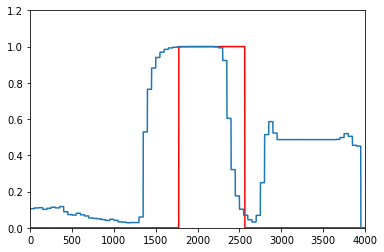

1
1992.wav
class - 1


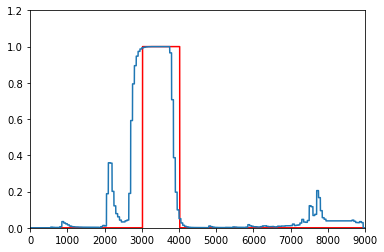

2
2035.wav
class - 1


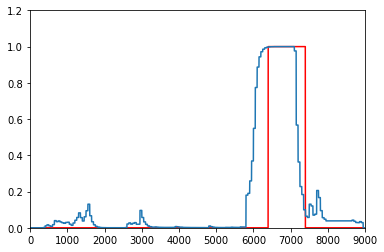

3
1973.wav
class - 0


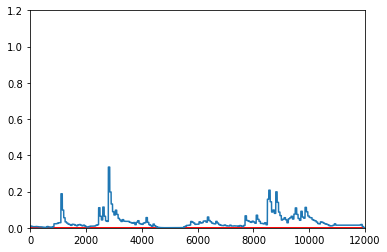

4
2922.wav
class - 0


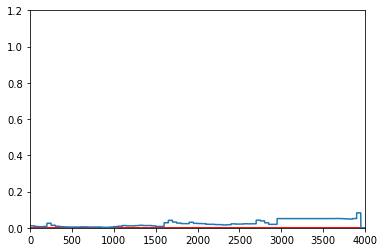

5
2007.wav
class - 1


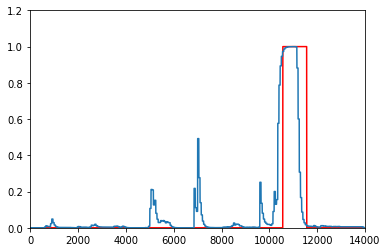

6
2939.wav
class - 0


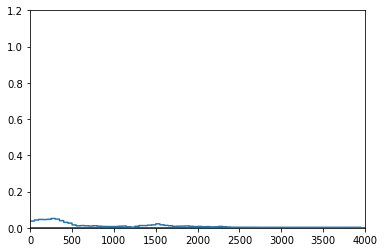

7
2950.wav
class - 0


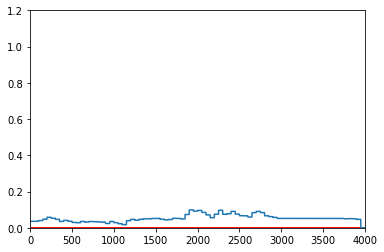

8
3665.wav
class - 1


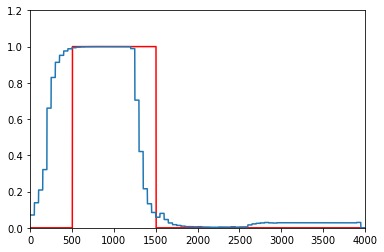

9
3499.wav
class - 1


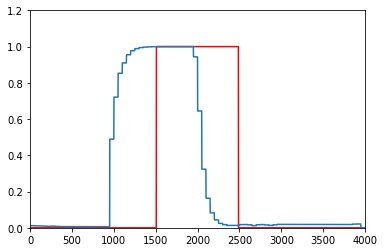

10
2014.wav
class - 0


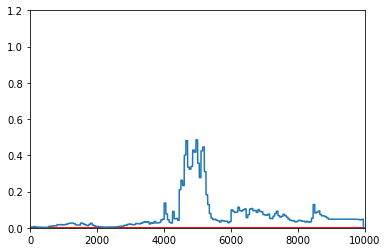

11
2871.wav
class - 0


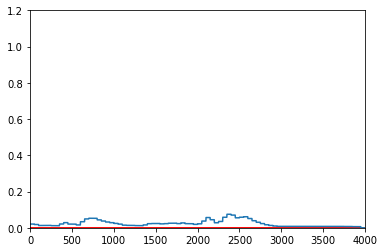

12
2925.wav
class - 0


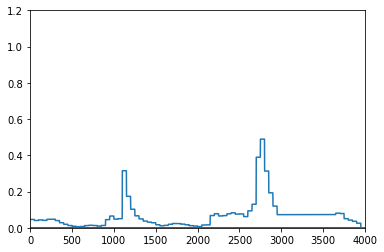

13
3385.wav
class - 1


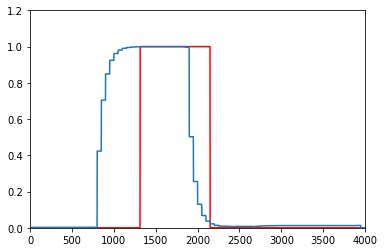

14
3526.wav
class - 1


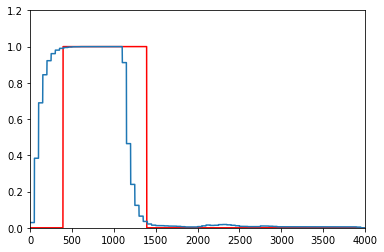

15
3456.wav
class - 1


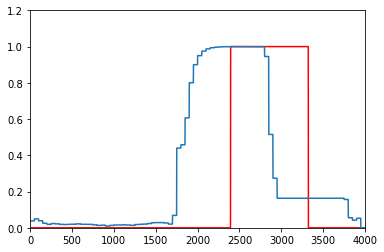

16
2913.wav
class - 0


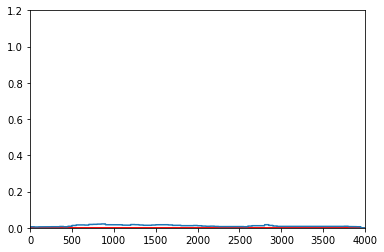

17
2001.wav
class - 1


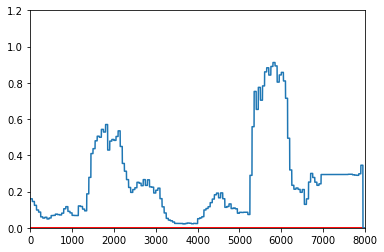

18
3457.wav
class - 1


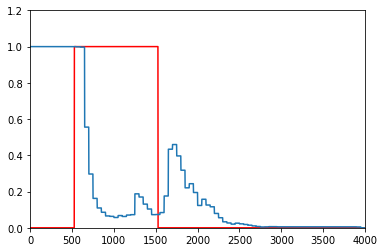

19
2992.wav
class - 0


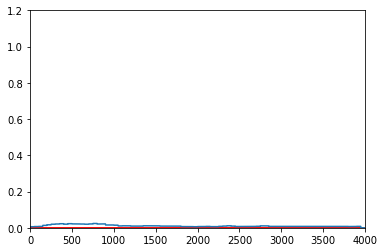

20
2862.wav
class - 0


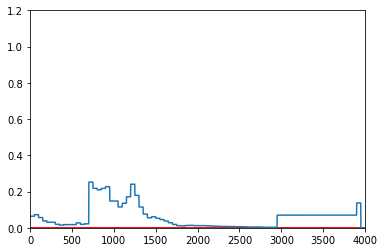

21
2902.wav
class - 0


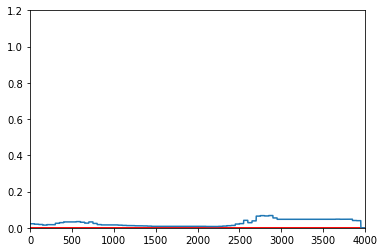

22
2903.wav
class - 0


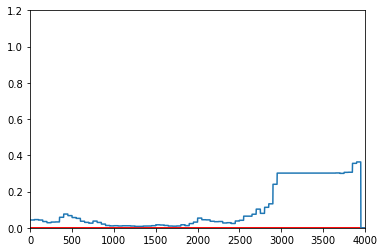

23
2878.wav
class - 0


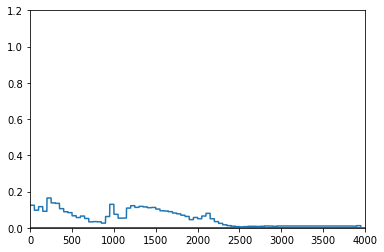

24
2004.wav
class - 0


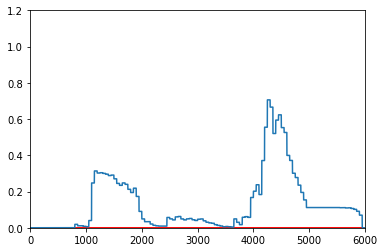

25
3434.wav
class - 1


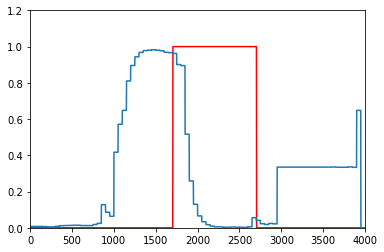

26
3399.wav
class - 1


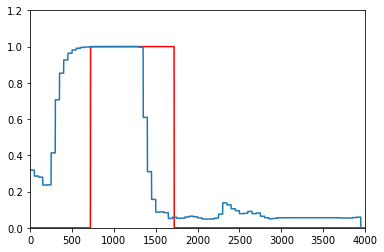

27
3543.wav
class - 1


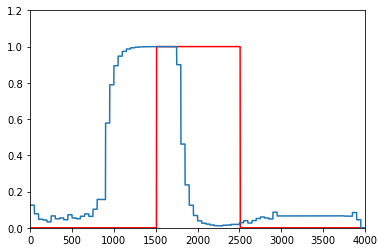

28
2051.wav
class - 0


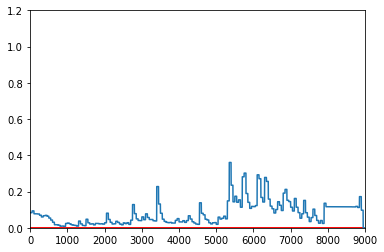

29
3473.wav
class - 1


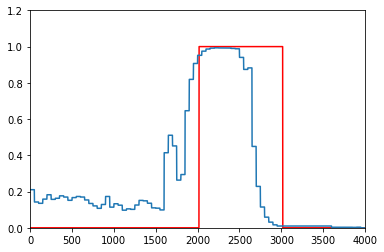

30
3655.wav
class - 1


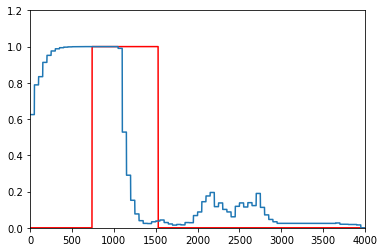

31
3418.wav
class - 1


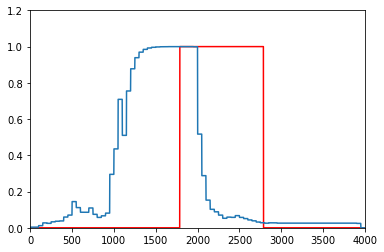

32
3558.wav
class - 1


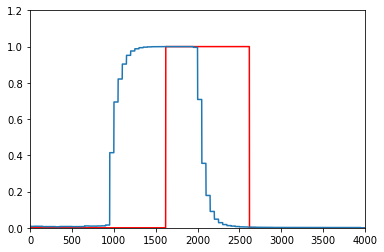

33
2900.wav
class - 0


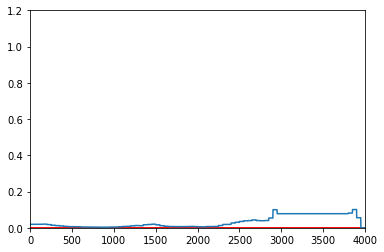

34
3401.wav
class - 1


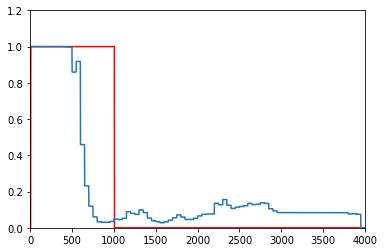

35
2797.wav
class - 0


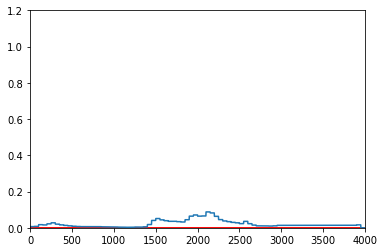

36
3420.wav
class - 1


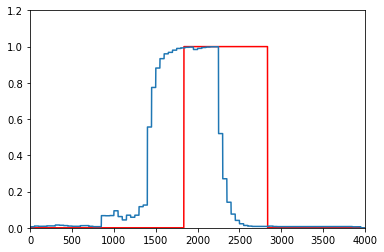

37
1935.wav
class - 1


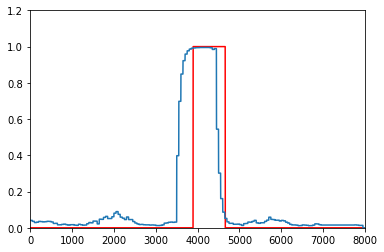

38
2964.wav
class - 0


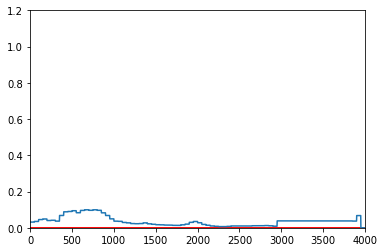

39
2025.wav
class - 1


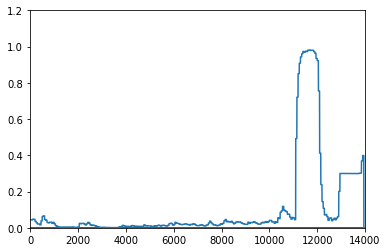

40
3415.wav
class - 1


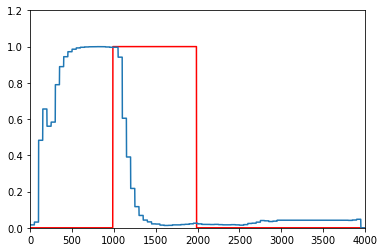

41
2969.wav
class - 0


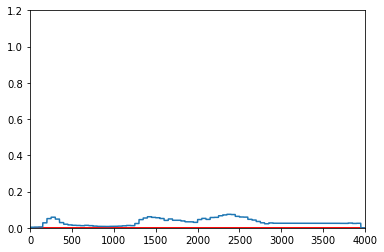

42
2852.wav
class - 0


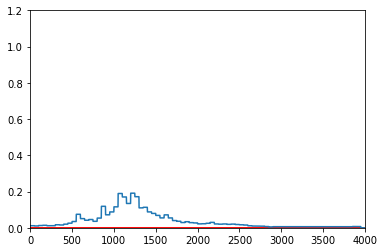

43
1924.wav
class - 1


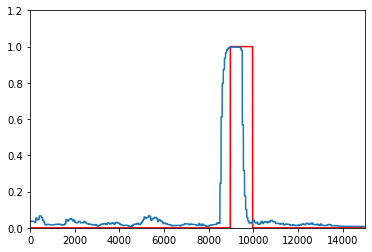

44
1991.wav
class - 0


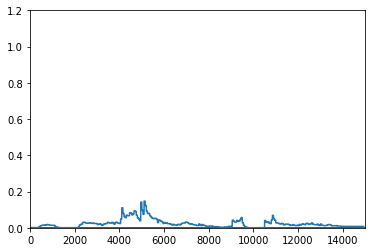

45
2011.wav
class - 1


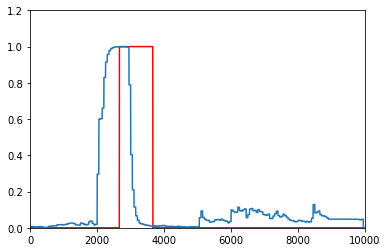

46
2809.wav
class - 0


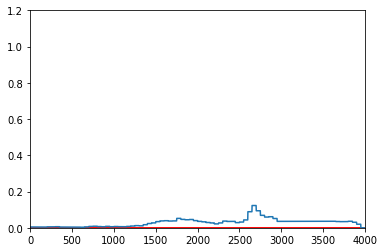

47
2810.wav
class - 0


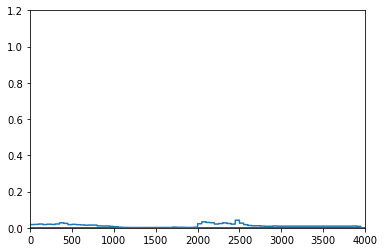

48
2016.wav
class - 0


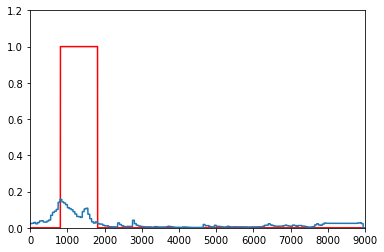

49
1928.wav
class - 1


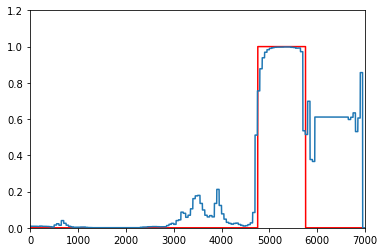

50
3437.wav
class - 1


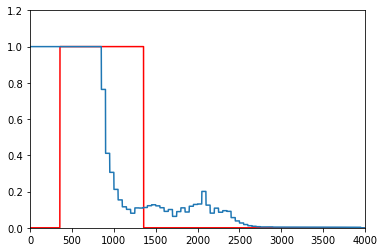

51
2014.wav
class - 1


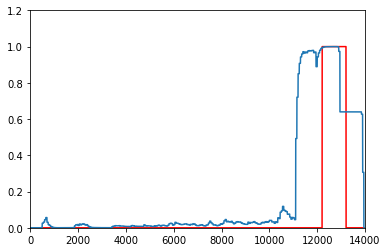

52
2019.wav
class - 1


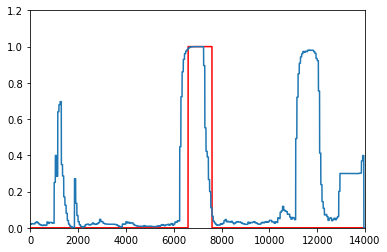

53
1993.wav
class - 1


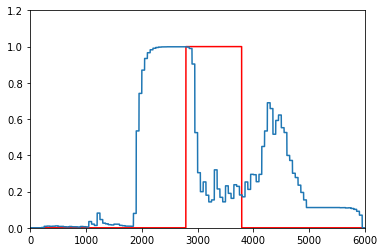

54
3597.wav
class - 1


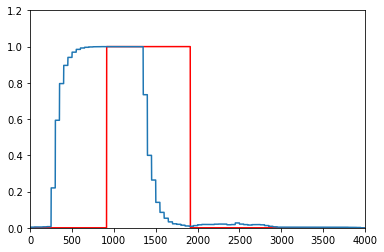

55
2030.wav
class - 0


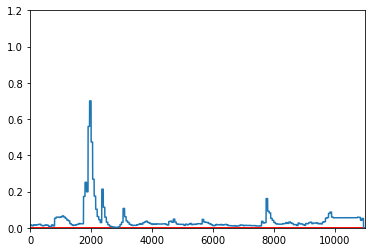

56
2010.wav
class - 0


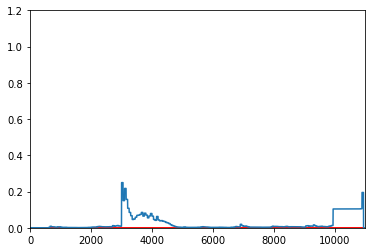

57
2967.wav
class - 0


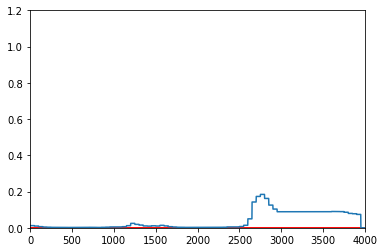

58
3516.wav
class - 1


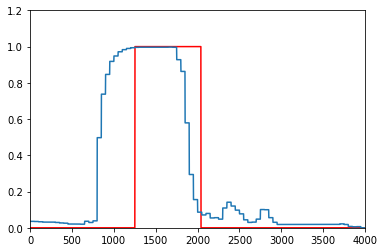

59
2050.wav
class - 1


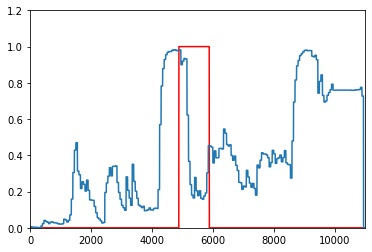

60
3622.wav
class - 1


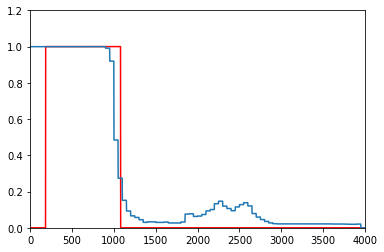

61
3603.wav
class - 1


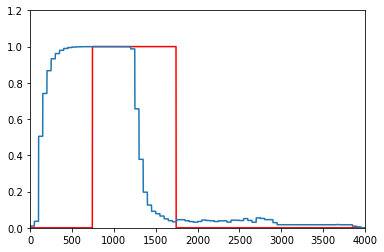

62
3396.wav
class - 1


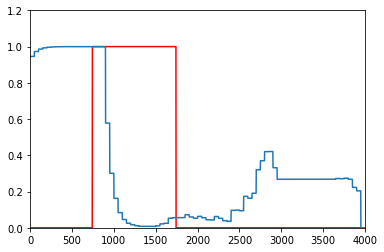

63
2933.wav
class - 0


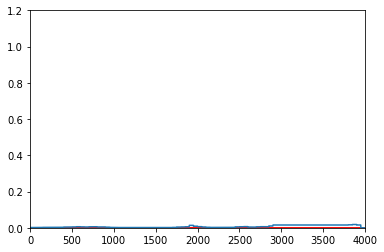

64
3364.wav
class - 1


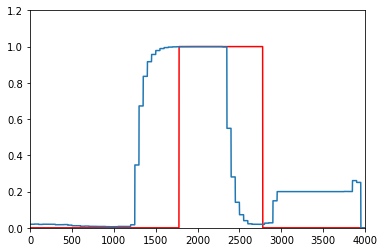

65
2942.wav
class - 0


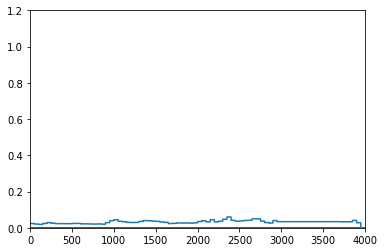

66
3535.wav
class - 1


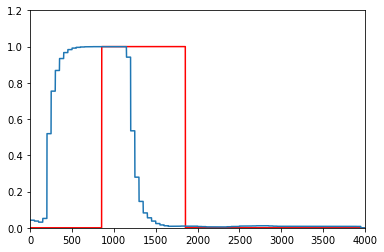

67
3639.wav
class - 1


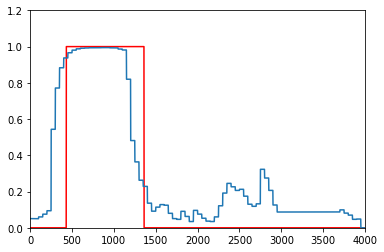

68
2983.wav
class - 0


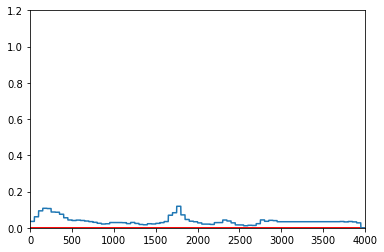

69
2882.wav
class - 0


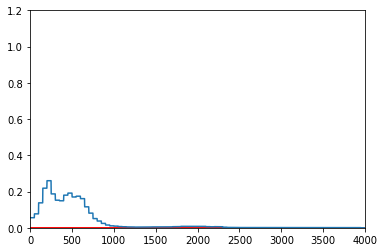

70
3640.wav
class - 1


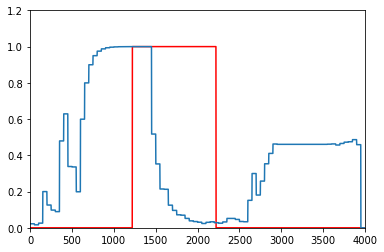

71
2876.wav
class - 0


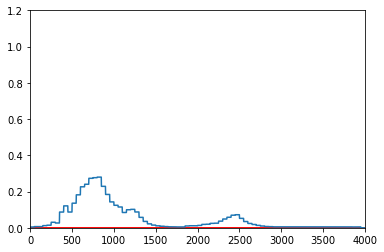

72
3584.wav
class - 1


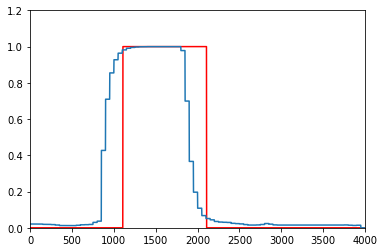

73
2965.wav
class - 0


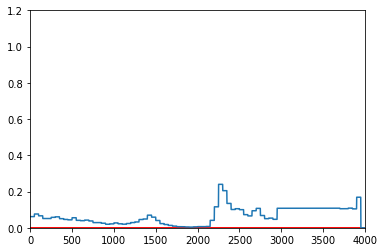

74
3466.wav
class - 1


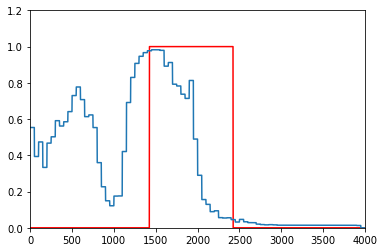

75
3607.wav
class - 1


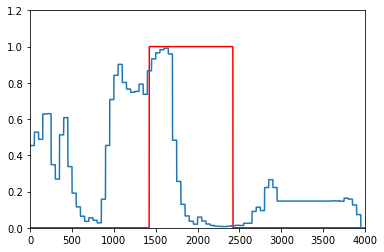

76
2921.wav
class - 0


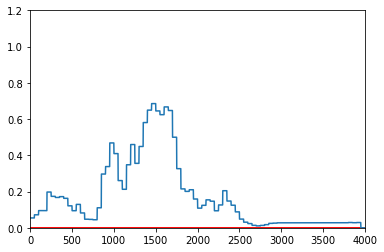

77
2885.wav
class - 0


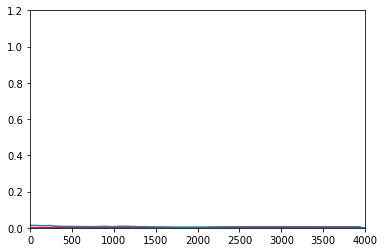

78
2838.wav
class - 0


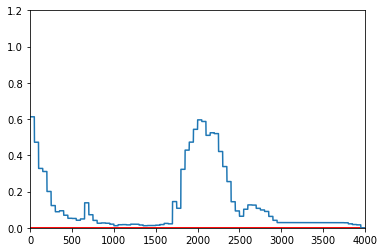

79
3616.wav
class - 1


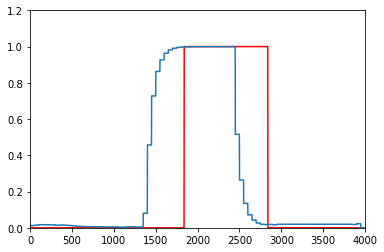

80
3608.wav
class - 1


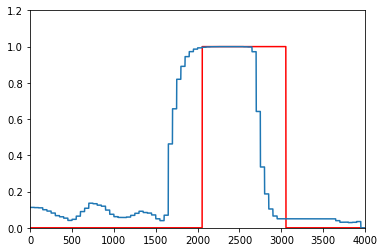

81
1962.wav
class - 1


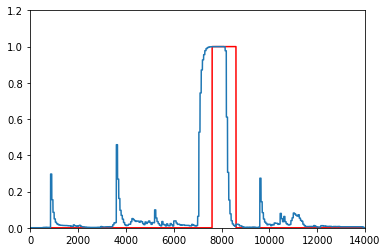

82
1990.wav
class - 0


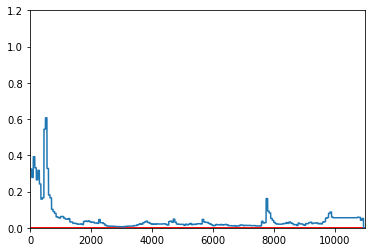

83
2919.wav
class - 1


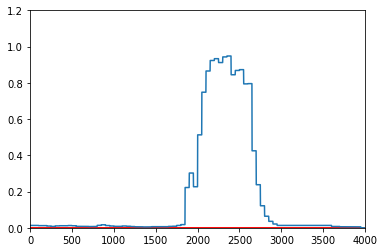

84
3384.wav
class - 1


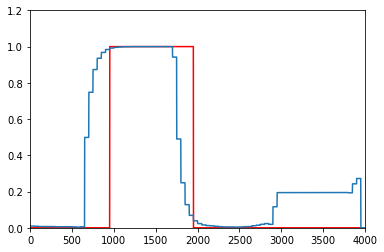

85
2954.wav
class - 0


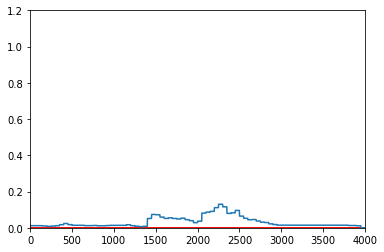

86
3423.wav
class - 0


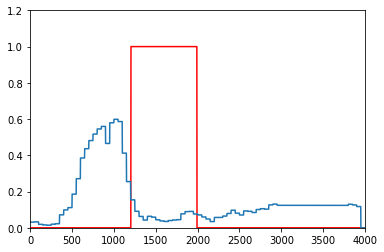

87
1989.wav
class - 1


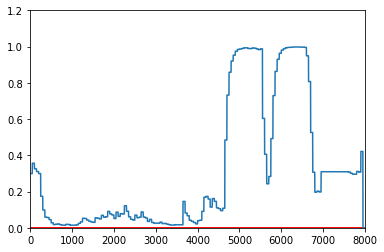

88
3562.wav
class - 1


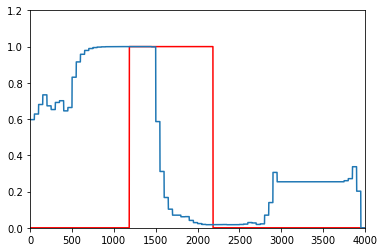

89
3588.wav
class - 1


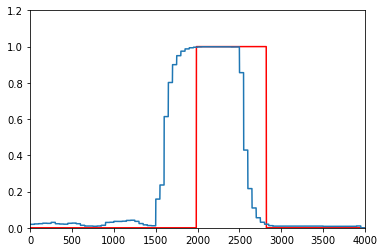

90
3505.wav
class - 1


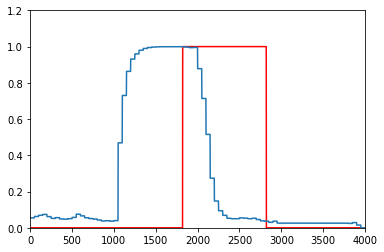

91
1943.wav
class - 1


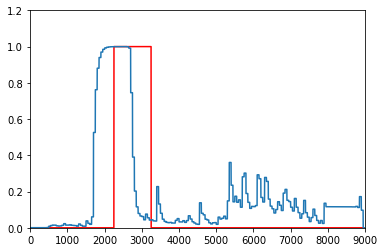

92
2053.wav
class - 1


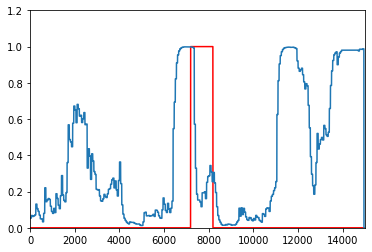

93
2033.wav
class - 1


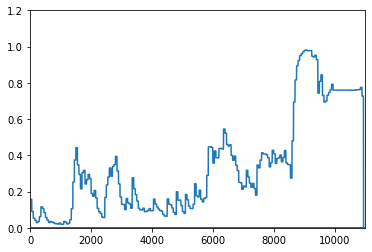

94
3432.wav
class - 1


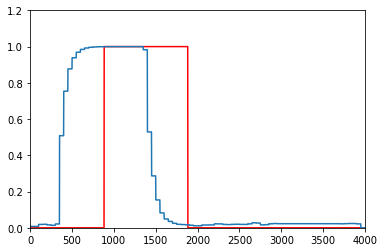

95
3394.wav
class - 1


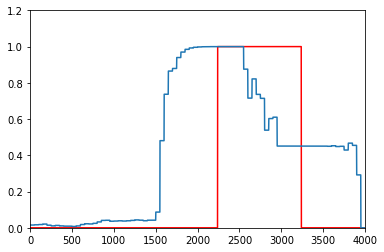

96
3626.wav
class - 1


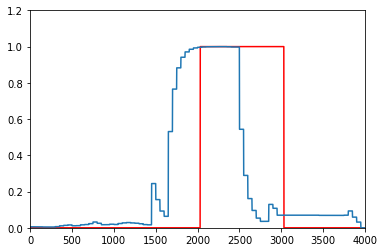

97
2840.wav
class - 0


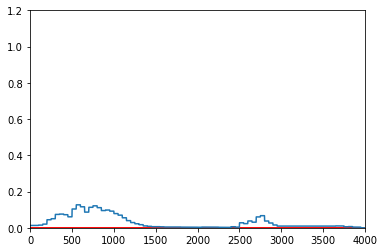

98
2003.wav
class - 1


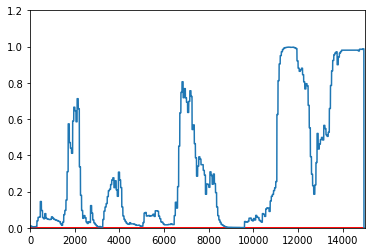

99
3657.wav
class - 1


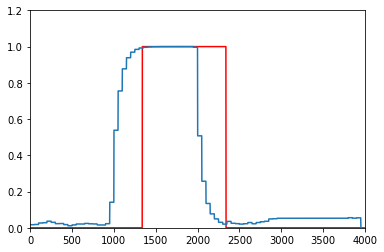

In [25]:
pr = []
for i, s in enumerate(test_sounds[:100]):
    real_values = []
    predicted_values = np.zeros((len(s),))
    predicted_values = predicted_values.tolist()
    if test_labels[i] == 0:
        real_values = [0 for k in range(len(s))]
        for j in range(0, len(s) - 1000, 50):
            sound = audiosegment_to_ndarray(s[j:j+1000])
            sound = np.expand_dims(sound, axis=0)
            pr_val = model.predict(sound)[0]
            fill_array(predicted_values, pr_val, j)
    else:
        start = 0
        end = 0
        if label_file[i] == 'o':
            start = border_dict[test_names[i]][0]
            end = border_dict[test_names[i]][1]
        else:
            start = new_border_dict[test_names[i]][0]
            end = new_border_dict[test_names[i]][1]
        real_values = [0 for k in range(len(s))]
        for k in range(int(start), int(end)):
            real_values[k] = 1
        for j in range(0, len(s) - 1000, 50):
            sound = audiosegment_to_ndarray(s[j:j+1000])
            sound = np.expand_dims(sound, axis=0)
            pr_val = model.predict(sound)[0]
            fill_array(predicted_values, pr_val, j)
    print(i)
    print(test_names[i])
    pr.append(make_pred(predicted_values))
    print('class - ' + str(pr[i]))
    xlim((0, len(predicted_values)))
    ylim(0, 1.2)
    plt.plot(real_values, color='red')
    plt.plot(predicted_values)
    plt.show()

In [26]:
accuracy_score(pr, test_labels[:100])

0.92

In [27]:
f1_score(pr, test_labels[:100])

0.9310344827586207